# Time Series Forecasting for Order

## Bu çalışmada doğuş teknoloji tarafından sağlanan veriseti kullanılmıştır. Veriseti 7,7 milyon satır ve 9 sütundan oluşmaktadır. Zamana bağlı olarak "Toplam Sipariş Adeti" tahmin edilmesi istenmektedir.
> ### Sütunların açıklamaları: 
>* part_number: Yedek Parça Numarası,
>* date: Sipariş Tarihi
>* order_key, order_key_line: Siparişe Özgü Anahtar Numaraları
>* supplied_quantity: Karşılanan Sipariş Adeti
>* firm_explanation: Bayi Adı
>* order_type: Sipariş Türü
>* price: Sipariş Fiyatı
>* order_quantity: Toplam Sipariş Adeti

# 1 - Veri Önişleme Ve Görselleştirme

## - Öncelikle gerekli kütüphaneleri çağıralım. Verimizin bulunduğu dizini görelim.

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/order-dataset/data.csv


## - Verimizi okuyalım

In [2]:
data = pd.read_csv('/kaggle/input/order-dataset/data.csv')
data.head()

,part_number,order_quantity,date,order_key,order_key_line,supplied_quantity,firm_explanation,order_type,price
0,7,1.0,2014-01-01,1250047,1250047-001,1.0,109,Acil,220.49
1,22,1.0,2014-01-01,623232,623232-001,1.0,1,Stok,13.56
2,29,3.0,2014-01-01,623232,623232-002,3.0,1,Stok,3.65
3,43,1.0,2014-01-01,1226488,1226488-001,1.0,157,Stok,8.82
4,52,1.0,2014-01-01,1226488,1226488-143,1.0,157,Stok,38.72


## Özniteliklerimizin veri yapılarını kontrol edelim. Veriler integer, float, object(belirsiz) gibi farklı yapılarda tutulmaktadır. Toplamda 7.708.479 satır ve 9 sütun bulunuyor. Veri RAM üzerinde yaklaşık 530MB'lık yer tutmaktadır.

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7708479 entries, 0 to 7708478
Data columns (total 9 columns):
 #   Column             Dtype  
---  ------             -----  
 0   part_number        int64  
 1   order_quantity     float64
 2   date               object 
 3   order_key          int64  
 4   order_key_line     object 
 5   supplied_quantity  float64
 6   firm_explanation   int64  
 7   order_type         object 
 8   price              float64
dtypes: float64(3), int64(3), object(3)
memory usage: 529.3+ MB


## - Verimizde farklı konumlarda boşluk(null,NaN) olabilir. Bu boşlukları çeşitli teknikler ile doldurabilir veya boşluk olan satırları verimizden silebiliriz. Bu çalışmada sağlanan veride boşluk bulunmuyor. Bu ince davranışlarından dolayı Doğuş Teknoloji'ye teşekkür ediyorum :))

In [4]:
data.isnull().any()

part_number          False
order_quantity       False
date                 False
order_key            False
order_key_line       False
supplied_quantity    False
firm_explanation     False
order_type           False
price                False
dtype: bool

## - Hem görselleştirme hem de verimizi doğru ayrıştırabilmek için öncelikle zaman belirten "date" sütunundaki verileri "datetime" objesine dönüştürelim

In [5]:
data['date'] = pd.to_datetime(data['date'])

## - Veriye ait çeşitli istatiksel bilgilere göz atalım.
## - Bu kısımda en çok dikkatimi çeken toplamda 317.101 siparişin karşılanamaması.

In [6]:
print('Veri Başlangıç/Bitiş Tarihi = {} || {}'.format(data['date'].min(),data['date'].max()))
print('Bir Siparişteki Ortalama/Min/Max Adet = {} || {} || {}'.format(data['order_quantity'].mean(),data['order_quantity'].min(),data['order_quantity'].max()))
print('Bir Siparişteki Ortalama Fiyat = {}'.format(data['price'].mean()))
print('En Pahalı/En Ucuz Ürünlerin Fiyatları = {} || {}'.format(data['price'].max(),data['price'].min()))
print('En Pahalı Ürünün Anahtar Numarası = {}'.format(data['order_key'].iloc[data['price'].idxmax()]))
print("Stokta {} adet ürün, acil olarak ise {} adet ürün isteniyor".format(data['order_type'].value_counts()['Stok'],data['order_type'].value_counts()['Acil']))
print('Karşılanamayan Sipariş Adeti = {} '.format(data['order_quantity'].sum() - data['supplied_quantity'].sum()))
print('En Çok Kullanılan Bayi Kodu ve Kullanılma Sayısı = {} || {} '.format(data['firm_explanation'].value_counts().index[0],data['firm_explanation'].value_counts().iloc[0]))
print('En Çok Sipariş Edilen Ürüne Ait Kod ve Sipariş Sayısı = {} || {} '.format(data['part_number'].value_counts().index[0],data['part_number'].value_counts().iloc[0]))

Veri Başlangıç/Bitiş Tarihi = 2014-01-01 00:00:00 || 2019-09-03 00:00:00
Bir Siparişteki Ortalama/Min/Max Adet = 5.044185240694046 || 1.0 || 9406.0
Bir Siparişteki Ortalama Fiyat = 443.40267403052434
En Pahalı/En Ucuz Ürünlerin Fiyatları = 374967.41 || 0.0
En Pahalı Ürünün Anahtar Numarası = 82352
Stokta 6118004 adet ürün, acil olarak ise 1590475 adet ürün isteniyor
Karşılanamayan Sipariş Adeti = 317101.0 
En Çok Kullanılan Bayi Kodu ve Kullanılma Sayısı = 63 || 318659 
En Çok Sipariş Edilen Ürüne Ait Kod ve Sipariş Sayısı = 1475 || 63346 


## - Küçük Bir Görselleştirmeyle Toplam Sipariş Adeti, Sipariş Fiyatları ve Karşılanan Siparişleri gösterelim.
## - Ekim 2016'da sipariş değerleri maksimum'a ulaştığı görülmektedir.
## - 2017 yılında birçok kez yüksek sipariş gelmesine rağmen bunun karşılanamadığı görülmektedir.

array([<AxesSubplot:xlabel='date'>, <AxesSubplot:xlabel='date'>,
       <AxesSubplot:xlabel='date'>], dtype=object)

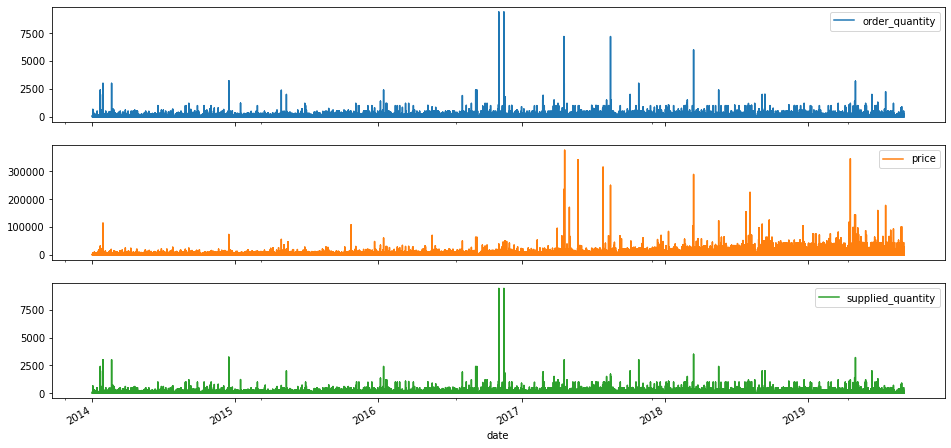

In [7]:
data.set_index('date')[['order_quantity','price','supplied_quantity']].plot(subplots=True,figsize=(16,8))

## - Siparişlerin drumunu yüzdesel olarak görselleştirelim

([<matplotlib.patches.Wedge at 0x7f6ec961f310>,
 [Text(-0.8768900577157763, 0.6641263634875689, 'Stok'),
  Text(0.8768900888057745, -0.6641263224373817, 'Acil')],
 [Text(-0.47830366784496886, 0.3622507437204921, '79.4%'),
  Text(0.47830368480314966, -0.3622507213294809, '20.6%')])

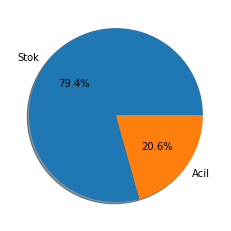

In [8]:
plt.pie(data['order_type'].value_counts(),labels=['Stok','Acil'],autopct='%1.1f%%',shadow=True)
#plt.show()

## - Karşılanamayan siparişleri görselleştirelim

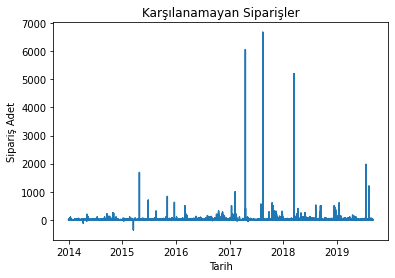

In [9]:
plt.plot(data['date'],data['order_quantity'] - data['supplied_quantity'])
plt.title('Karşılanamayan Siparişler')
plt.xlabel('Tarih')
plt.ylabel('Sipariş Adet')
plt.show()

## - Verimizi her güne ait öznitelikler toplanacak şekilde gruplayalım. 

In [10]:
data = data.groupby(data['date'].dt.date).sum()

In [11]:
data.head()

,part_number,order_quantity,order_key,supplied_quantity,firm_explanation,price
date,,,,,,
2014-01-01,460920,1795.0,295112505,1790.0,32279,76809.27
2014-01-02,5593129,28511.0,4093899557,28220.0,461401,1510200.49
2014-01-03,3081757,13512.0,2381407727,13446.0,250319,667465.16
2014-01-04,1159459,5091.0,912544257,5070.0,90869,276405.79
2014-01-06,3767803,17178.0,2767915840,17118.0,288604,833507.28


## - Verimizdeki 'part_number', 'order_key', 'firm_explanation' sütunları aslında sayısal ifadeler gibi görünse de kategorik niteliklerdir.
## - Bu kategorik değerlerin(güne bağlı olarak) toplanması anlamsızdır. Bundan dolayı bu sütunları verimizden siliyorum.
## - Verimizde sadece gün bilgisi verildiği için siparişe özel bir tahmin yapmadım. Saat bilgisi verilseydi siparişe özel bir tahmin güzel olabilirdi.

In [12]:
data = data[['order_quantity','supplied_quantity','price']]
# data['diffrence_quantity'] = data['order_quantity'] - data['supplied_quantity']
data.head()

,order_quantity,supplied_quantity,price
date,,,
2014-01-01,1795.0,1790.0,76809.27
2014-01-02,28511.0,28220.0,1510200.49
2014-01-03,13512.0,13446.0,667465.16
2014-01-04,5091.0,5070.0,276405.79
2014-01-06,17178.0,17118.0,833507.28


array([<AxesSubplot:xlabel='date'>, <AxesSubplot:xlabel='date'>,
       <AxesSubplot:xlabel='date'>], dtype=object)

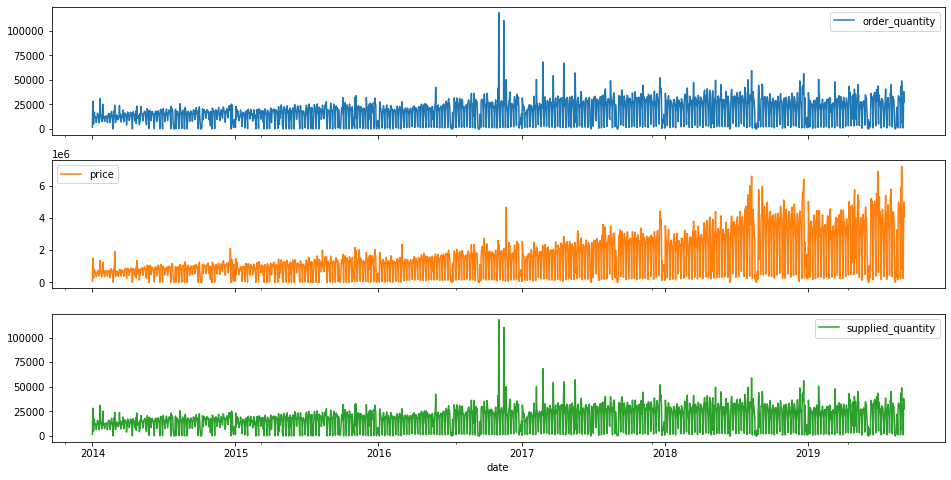

In [13]:
data[['order_quantity','price','supplied_quantity']].plot(subplots=True,figsize=(16,8))

## - Artık verimiz hazır olduğuna göre normalizasyon işleminden geçirelim. Böylece hem daha daha az yer kaplar hem de özniteliklerin birbiri üzerine baskı yapmasını önlemiş oluruz.

In [14]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)
data_scaled

array([[0.01512979, 0.01514228, 0.01067653],
       [0.24044057, 0.23884854, 0.20991859],
       [0.11394572, 0.11379987, 0.09277798],
       ...,
       [0.00999376, 0.00991993, 0.03483633],
       [0.32383153, 0.32363347, 0.69080982],
       [0.23338169, 0.23297446, 0.56557831]])

## - Verimizi input-output olarak ayıralım.

In [15]:
features = data_scaled
target = data_scaled[:,0]

## - Verimizi eğitim ve test olarak ayrıştırıyoruz. Burdaki önemli nokta shuffle(veri karıştırma) parametresini "False" olarak vermeliyiz çünkü verimiz zamana bağlı olarak değişmektedir. Rastgele karıştırılması verinin anlamını bozacaktır. 
## - Verinin %20'lik bölümü test seti olarak ayrıştırılmıştır.

In [16]:
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.20, random_state=123,shuffle=False)

2021-10-07 22:16:29.311678: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib
2021-10-07 22:16:29.311825: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


# Sırayla verimizin boyutlarına bir göz atalım.

In [17]:
print('Eğitim Kümesi Boyutları: ',X_train.shape)
print('Eğitim Kümesi Etiket Boyutları: ',y_train.shape)
print('Test Kümesi Boyutları: ',X_test.shape)
print('Test Kümesi Etiket Boyutları: ',y_test.shape)

Eğitim Kümesi Boyutları:  (1617, 3)
Eğitim Kümesi Etiket Boyutları:  (1617,)
Test Kümesi Boyutları:  (405, 3)
Test Kümesi Etiket Boyutları:  (405,)


## - Verimize pencere boyutu ekleyelim. 
## - Verimiz zamana bağlı değiştiği için uygun şekilde yığınlanması gerekmektedir. Bundan dolayı "tensorflow" kütüphanesinin "TimeSeriesGenerator" fonksiyonu kullanılmıştır.

In [18]:
win_length = 20
batch_size  = 32
num_features = 3
train_generator = TimeseriesGenerator(X_train,y_train,length=win_length,batch_size=batch_size)
test_generator = TimeseriesGenerator(X_test,y_test,length=win_length,batch_size=batch_size)

# 2 - Model Kurma

## Neden LSTM? 
## Çoklu girdileri beraber değerlendiren RNN tabanlı bir yapıdır. Zaman serilerinde ve sıralı verilerde güzel sonuçlar vermektedir. Eski girdileri "Hidden State" olarak tutarak anlık çıktıyı eski girdilerle beraber değerlendirir.
### - 128 nörona sahip 3 adet LSTM katmanları kullanılmıştır. 
### - Katmanlar arası aktivasyon fonksiyonu olarak "LeakyRelu" kullanılmıştır.
### - Aşırı öğrenmeyi önlemek için "Dropout" katmanları eklenmiştir.

In [19]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(128,input_shape=(win_length,num_features),return_sequences=True))
model.add(tf.keras.layers.LeakyReLU(alpha=0.5))
model.add(tf.keras.layers.LSTM(128,return_sequences=True))
model.add(tf.keras.layers.LeakyReLU(alpha=0.5))
model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.LSTM(128,return_sequences=False))
model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.Dense(1))
model.summary()

2021-10-07 22:16:34.544607: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-10-07 22:16:34.547499: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib
2021-10-07 22:16:34.547536: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2021-10-07 22:16:34.547563: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (58c64fe1b9fa): /proc/driver/nvidia/version does not exist
2021-10-07 22:16:34.548832: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operation

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 20, 128)           67584     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 20, 128)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 20, 128)           131584    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 20, 128)           0         
_________________________________________________________________
dropout (Dropout)            (None, 20, 128)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0

## - Eğitim esnasında aşırı öğrenme veya az öğrenmeyi engellemek için Erken Durdurma tanımlanmıştır. Son 8 validasyon kayıp fonksiyonuna bakarak azalma olmadığı taktirde eğitimi durdurmaktadır.
## - Artık modelimizi kurabiliriz.
## - Optimizer fonksiyonu olarak "Adam" seçilmiştir.
## - Çözmemiz gerek regresif bir problem olduğu için kayıp fonksiyonu "Mean Squared Loss", metrik olarak da "Mean Absolute Loss" kullanılmıştır.

In [20]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=8,mode='min')
model.compile(loss=tf.losses.MeanSquaredError(),optimizer=tf.optimizers.Adam(), metrics=[tf.metrics.MeanAbsoluteError()])

## - Artık eğitime başlayabiliriz. 
## - 50 epochluk bir eğitim tanımlanmıştır.
## - Eğitim sonuçları history değişkeninde tutulmuştur. 
## - Modele ait güncellenen ağırlıklar model değişkeninde tutulmaktadır.

In [21]:
history = model.fit_generator(train_generator, epochs=50, validation_data=test_generator,shuffle=False,callbacks=[early_stopping])

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
2021-10-07 22:16:36.055874: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2021-10-07 22:16:36.061769: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2200150000 Hz


Epoch 1/50
50/50 [==============================] - 10s 103ms/step - loss: 0.0061 - mean_absolute_error: 0.0615 - val_loss: 0.0112 - val_mean_absolute_error: 0.0833
Epoch 2/50
50/50 [==============================] - 4s 73ms/step - loss: 0.0053 - mean_absolute_error: 0.0575 - val_loss: 0.0107 - val_mean_absolute_error: 0.0838
Epoch 3/50
50/50 [==============================] - 4s 74ms/step - loss: 0.0053 - mean_absolute_error: 0.0574 - val_loss: 0.0108 - val_mean_absolute_error: 0.0827
Epoch 4/50
50/50 [==============================] - 4s 75ms/step - loss: 0.0056 - mean_absolute_error: 0.0594 - val_loss: 0.0108 - val_mean_absolute_error: 0.0824
Epoch 5/50
50/50 [==============================] - 4s 73ms/step - loss: 0.0059 - mean_absolute_error: 0.0608 - val_loss: 0.0110 - val_mean_absolute_error: 0.0818
Epoch 6/50
50/50 [==============================] - 4s 74ms/step - loss: 0.0059 - mean_absolute_error: 0.0616 - val_loss: 0.0112 - val_mean_absolute_error: 0.0817
Epoch 7/50
50/50 [==

## - Kayıp fonksiyonumuzu ve metrik değerimizi görselleştirelim.
## - İki kayıp fonksiyonu değeri için de azalma olduğu görülmektedir. Çeşitli hiperparametre ayarlamarıyla daha stabil bir eğitim oluşturulabilir.

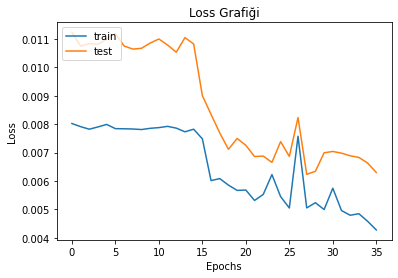

In [22]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss Grafiği')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

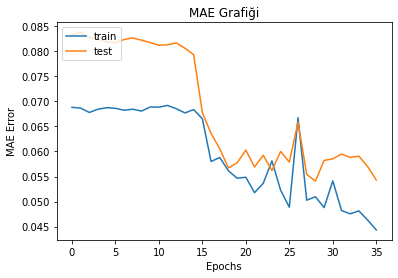

In [23]:
plt.plot(history.history['mean_absolute_error'])
plt.plot(history.history['val_mean_absolute_error'])
plt.title('MAE Grafiği')
plt.ylabel('MAE Error')
plt.xlabel('Epochs')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# - Eğitilen modeli test seti üzerinde deneyelim.
# - 0,0063 değerinde bir MSE, 0,054 değerinde bir MAE elde ettik.

In [24]:
model.evaluate_generator(test_generator)

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


[0.006298254244029522, 0.054307546466588974]

# - Test setindeki değerleri model ile tahmin edelim.

In [25]:
predictions = model.predict_generator(test_generator)
predictions.shape[0]

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


385

# - Tahmin ettiğimiz değerler çıktı olarak normalize olmuş haldedir. Bunu normal değerlere çekmek için (daha önce kullandığımız)MinMaxScaler fonksiyonunun inverse_transform metotunu kullanıyoruz. Daha sonra Final verimize tahmin edilen veriyi ekleyip görselleştiriyoruz.

In [26]:
df_pred = pd.concat([pd.DataFrame(predictions),pd.DataFrame(X_test[:,1:][win_length:])],axis=1)
rev_trans = scaler.inverse_transform(df_pred)
df_final = data[predictions.shape[0]*-1:]
df_final['Predicted_Order_Quantity'] = rev_trans[:,0]
deneme_1_pred = df_final['Predicted_Order_Quantity']
df_final

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,order_quantity,supplied_quantity,price,Predicted_Order_Quantity
date,,,,
2018-08-14,38122.0,37883.0,4498400.12,27042.305262
2018-08-15,31202.0,30869.0,3806552.43,30647.008813
2018-08-16,30597.0,30376.0,3606241.43,31349.245222
2018-08-17,23062.0,22870.0,2865602.04,29489.458911
2018-08-18,20067.0,20001.0,2747557.04,23970.506423
...,...,...,...,...
2019-08-30,5843.0,5820.0,809265.11,28460.146373
2019-08-31,13879.0,13811.0,1801471.05,18271.239247
2019-09-01,1186.0,1173.0,250620.23,8513.422430


# - Tahmin edilen ve Test setine ait olan değerleri görselleştirelim

Text(0.5, 0, 'Zaman')

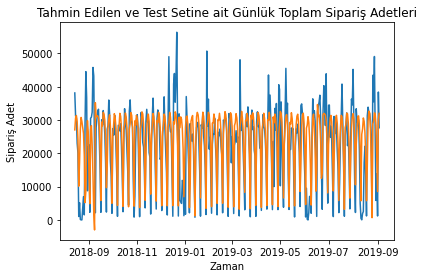

In [27]:
plt.plot(df_final['order_quantity'])
plt.plot(df_final['Predicted_Order_Quantity'])
plt.title('Tahmin Edilen ve Test Setine ait Günlük Toplam Sipariş Adetleri')
plt.ylabel('Sipariş Adet')
plt.xlabel('Zaman')

# - LSTM'ler ile ilk denememizi yaptık. Model üzerinde hiperparametre optimizasyonları gibi teknikler ile eğitim safhasından daha güzel sonuçlar alınabilir.
# - Fakat bu çalışmada bütün modellerde optimizasyon yapmadan karşılaştırmak istiyorum.
# - Bu denemede test verisetine ait ulaşılan MSE değeri = 0,0063

# Deneme 2
## - Şimdi farklı bir hafızalı ağ yapısı olan GRU ile benzer bir model kuralım.
## - Önceki modellerle aynı parametreler kullanılarak GRU tabanlı bir model kurulmuştur.
## - GRU tabanlı modelde 250.000, LSTM tabanlı modelde 330.000 parametre blunuyor. Burdan GRU'nun LSTM'e göre daha hafif bir ağ yapısı olduğunu söyleyebiliriz.

In [28]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.GRU(128,input_shape=(win_length,num_features),return_sequences=True))
model.add(tf.keras.layers.LeakyReLU(alpha=0.5))
model.add(tf.keras.layers.GRU(128,return_sequences=True))
model.add(tf.keras.layers.LeakyReLU(alpha=0.5))
model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.GRU(128,return_sequences=False))
model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.Dense(1))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 20, 128)           51072     
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 20, 128)           0         
_________________________________________________________________
gru_1 (GRU)                  (None, 20, 128)           99072     
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 20, 128)           0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 20, 128)           0         
_________________________________________________________________
gru_2 (GRU)                  (None, 128)               99072     
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)              

## - Önceki denememizle aynı erken durdurma tanımlayalım.
## - Karşılaştırabilmek için önceki modelle aynı metrikleri kullanalım.

In [29]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=8,mode='min')
model.compile(loss=tf.losses.MeanSquaredError(),optimizer=tf.optimizers.Adam(), metrics=[tf.metrics.MeanAbsoluteError()])

# - 50 Epoch'luk bir eğitim yapalım.
# - İlk olarak eğitimin daha hızlı gerçekleştiğini gözlemliyoruz. Adım başına geçen zaman GRU'da LSTM'e göre daha az.
# - LSTM denemesinde 38. adımda eğitim erkenden durdurulmuştu. GRU denemesinde ise aynı parametrelerle 32. adımda daha iyi bir MSE skoruyla durduruldu.

In [30]:
history = model.fit_generator(train_generator, epochs=50, validation_data=test_generator,shuffle=False,callbacks=[early_stopping])

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
50/50 [==============================] - 8s 76ms/step - loss: 0.0064 - mean_absolute_error: 0.0623 - val_loss: 0.0106 - val_mean_absolute_error: 0.0818
Epoch 2/50
50/50 [==============================] - 3s 56ms/step - loss: 0.0062 - mean_absolute_error: 0.0633 - val_loss: 0.0103 - val_mean_absolute_error: 0.0802
Epoch 3/50
50/50 [==============================] - 3s 56ms/step - loss: 0.0065 - mean_absolute_error: 0.0649 - val_loss: 0.0091 - val_mean_absolute_error: 0.0714
Epoch 4/50
50/50 [==============================] - 3s 56ms/step - loss: 0.0056 - mean_absolute_error: 0.0590 - val_loss: 0.0079 - val_mean_absolute_error: 0.0668
Epoch 5/50
50/50 [==============================] - 3s 55ms/step - loss: 0.0045 - mean_absolute_error: 0.0528 - val_loss: 0.0073 - val_mean_absolute_error: 0.0654
Epoch 6/50
50/50 [==============================] - 3s 57ms/step - loss: 0.0045 - mean_absolute_error: 0.0525 - val_loss: 0.0060 - val_mean_absolute_error: 0.0559
Epoch 7/50
50/50 [====

# - Hemen eğitim değerlerini görselleştirelim.
# - GRU yapısı bu testimizde LSTM'e göre daha stabil bir grafik izlediği gözlenmiştir.

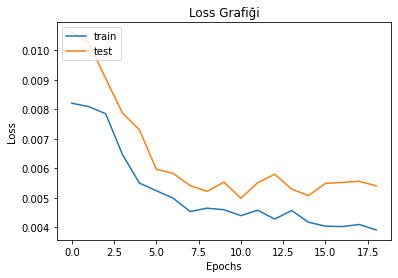

In [31]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss Grafiği')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

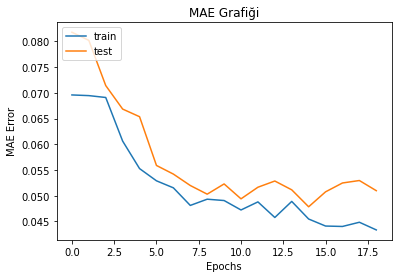

In [32]:
plt.plot(history.history['mean_absolute_error'])
plt.plot(history.history['val_mean_absolute_error'])
plt.title('MAE Grafiği')
plt.ylabel('MAE Error')
plt.xlabel('Epochs')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## - Test verisetinde 0.0051 MSE değerine ulaştığını gözlemliyoruz.

In [33]:
model.evaluate_generator(test_generator)

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


[0.005403939168900251, 0.050988368690013885]

# - Tahmin ettiğimiz değerler çıktı olarak normalize olmuş haldedir. Bunu normal değerlere çekmek için (daha önce kullandığımız)MinMaxScaler fonksiyonunun inverse_transform metotunu kullanıyoruz. Daha sonra Final verimize tahmin edilen veriyi ekleyip görselleştiriyoruz.

In [34]:
predictions = model.predict_generator(test_generator)
predictions.shape[0]
df_pred = pd.concat([pd.DataFrame(predictions),pd.DataFrame(X_test[:,1:][win_length:])],axis=1)
rev_trans = scaler.inverse_transform(df_pred)
df_final = data[predictions.shape[0]*-1:]
df_final['Predicted_Order_Quantity'] = rev_trans[:,0]
deneme_2_pred = df_final['Predicted_Order_Quantity']
df_final

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,order_quantity,supplied_quantity,price,Predicted_Order_Quantity
date,,,,
2018-08-14,38122.0,37883.0,4498400.12,37668.743896
2018-08-15,31202.0,30869.0,3806552.43,36196.634516
2018-08-16,30597.0,30376.0,3606241.43,34321.875577
2018-08-17,23062.0,22870.0,2865602.04,30459.665435
2018-08-18,20067.0,20001.0,2747557.04,18667.782434
...,...,...,...,...
2019-08-30,5843.0,5820.0,809265.11,32173.556082
2019-08-31,13879.0,13811.0,1801471.05,7345.417839
2019-09-01,1186.0,1173.0,250620.23,12674.453474


# - Tahmin edilen ve Test setine ait olan değerleri görselleştirelim

Text(0.5, 0, 'Zaman')

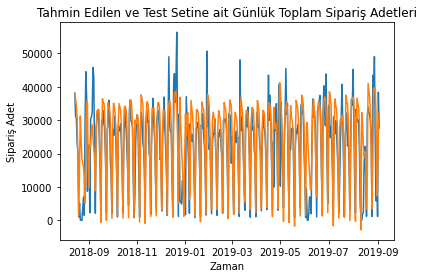

In [35]:
plt.plot(df_final['order_quantity'])
plt.plot(df_final['Predicted_Order_Quantity'])
plt.title('Tahmin Edilen ve Test Setine ait Günlük Toplam Sipariş Adetleri')
plt.ylabel('Sipariş Adet')
plt.xlabel('Zaman')

# Deneme 3 -> Are deeper networks better?

# - Sıradaki modelimizde açıkcası bir soruyu test etmek istiyorum. Genelde yapay sinir ağlarında şöyle bir algı vardır: "Daha derin ve daha yoğun ağlar daha iyi sonuç verir". Bu soruyu test etmek istiyorum.
# - Bu denemede daha hızlı ve daha iyi sonuç verdiği için GRU kullanmak istiyorum.
# - Önceki denemeden farklı olarak daha fazla nöron ve daha fazla katman kullanmak istiyorum.
# - 128 nöronluk bir GRU katmanı eklenmiştir.
# - 1. ve 3. katmanlardaki nöron sayısı iki katına çıkarılmıştır.

In [36]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.GRU(256,input_shape=(win_length,num_features),return_sequences=True))
model.add(tf.keras.layers.LeakyReLU(alpha=0.5))
model.add(tf.keras.layers.GRU(128,return_sequences=True))
model.add(tf.keras.layers.LeakyReLU(alpha=0.5))
model.add(tf.keras.layers.GRU(256,return_sequences=True))
model.add(tf.keras.layers.LeakyReLU(alpha=0.5))
model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.GRU(128,return_sequences=False))
model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.Dense(1))
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_3 (GRU)                  (None, 20, 256)           200448    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 20, 256)           0         
_________________________________________________________________
gru_4 (GRU)                  (None, 20, 128)           148224    
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 20, 128)           0         
_________________________________________________________________
gru_5 (GRU)                  (None, 20, 256)           296448    
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 20, 256)           0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 20, 256)          

# - Öncelikle daha yoğun ve derin ağ olduğu için adımlar daha yavaş gerçekleşiyor.
# - Eğitim 34. adımda durduruluyor. Test seti için 0,0043 MSE değerine ulaştığı gözlemleniyor.

In [37]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=8,mode='min')
model.compile(loss=tf.losses.MeanSquaredError(),optimizer=tf.optimizers.Adam(), metrics=[tf.metrics.MeanAbsoluteError()])
history = model.fit_generator(train_generator, epochs=50, validation_data=test_generator,shuffle=False,callbacks=[early_stopping])

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
50/50 [==============================] - 13s 139ms/step - loss: 0.0063 - mean_absolute_error: 0.0621 - val_loss: 0.0107 - val_mean_absolute_error: 0.0822
Epoch 2/50
50/50 [==============================] - 6s 118ms/step - loss: 0.0061 - mean_absolute_error: 0.0623 - val_loss: 0.0105 - val_mean_absolute_error: 0.0819
Epoch 3/50
50/50 [==============================] - 6s 113ms/step - loss: 0.0062 - mean_absolute_error: 0.0629 - val_loss: 0.0101 - val_mean_absolute_error: 0.0799
Epoch 4/50
50/50 [==============================] - 6s 115ms/step - loss: 0.0056 - mean_absolute_error: 0.0590 - val_loss: 0.0080 - val_mean_absolute_error: 0.0645
Epoch 5/50
50/50 [==============================] - 6s 115ms/step - loss: 0.0056 - mean_absolute_error: 0.0582 - val_loss: 0.0075 - val_mean_absolute_error: 0.0637
Epoch 6/50
50/50 [==============================] - 6s 113ms/step - loss: 0.0042 - mean_absolute_error: 0.0494 - val_loss: 0.0062 - val_mean_absolute_error: 0.0578
Epoch 7/50
50/5

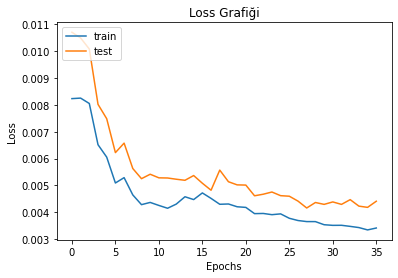

In [38]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss Grafiği')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

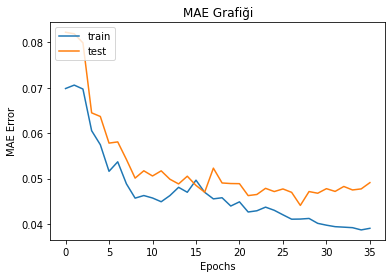

In [39]:
plt.plot(history.history['mean_absolute_error'])
plt.plot(history.history['val_mean_absolute_error'])
plt.title('MAE Grafiği')
plt.ylabel('MAE Error')
plt.xlabel('Epochs')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# - Test seti için 0,0043 MSE skoru gözlemleniyor. Bu şuana kadar elde edilmiş en iyi değer.

In [40]:
model.evaluate_generator(test_generator)

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


[0.0044131153263151646, 0.049107275903224945]

# - Tahmin edilen ve test setine ait değerleri bir veri üzerinde tutalım.

In [41]:
predictions = model.predict_generator(test_generator)
predictions.shape[0]
df_pred = pd.concat([pd.DataFrame(predictions),pd.DataFrame(X_test[:,1:][win_length:])],axis=1)
rev_trans = scaler.inverse_transform(df_pred)
df_final = data[predictions.shape[0]*-1:]
df_final['Predicted_Order_Quantity'] = rev_trans[:,0]
deneme_3_pred = df_final['Predicted_Order_Quantity']
df_final

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,order_quantity,supplied_quantity,price,Predicted_Order_Quantity
date,,,,
2018-08-14,38122.0,37883.0,4498400.12,30687.866384
2018-08-15,31202.0,30869.0,3806552.43,34767.170801
2018-08-16,30597.0,30376.0,3606241.43,28310.996096
2018-08-17,23062.0,22870.0,2865602.04,23250.936819
2018-08-18,20067.0,20001.0,2747557.04,13360.205681
...,...,...,...,...
2019-08-30,5843.0,5820.0,809265.11,26263.034202
2019-08-31,13879.0,13811.0,1801471.05,3330.490069
2019-09-01,1186.0,1173.0,250620.23,5869.711513


# - Tahmin ve test setine ait değerleri görselleştirelim.
# - En iyi MSE değerine(0,0043) bu denemede ulaştık. Yani kısaca daha yoğun ve derin bir ağ daha iyi sonuç elde edebiliyor :)

Text(0.5, 0, 'Zaman')

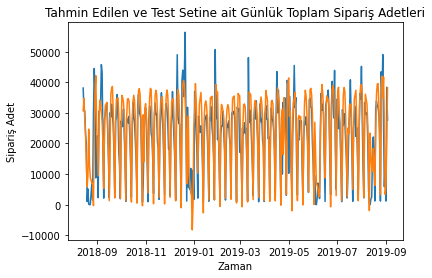

In [42]:
plt.plot(df_final['order_quantity'])
plt.plot(df_final['Predicted_Order_Quantity'])
plt.title('Tahmin Edilen ve Test Setine ait Günlük Toplam Sipariş Adetleri')
plt.ylabel('Sipariş Adet')
plt.xlabel('Zaman')

# Deneme 4 - Random Forest Regressor
## - Bu denemede daha ilkel bir makine öğrenmesi yöntemi kullanmaya karar verdim. RandomForest Regressor tercih edilmiştir.
## - Veri öncelikle "features" ve "etiket" şeklinde ayrıştırılmıştır.
## - Daha sonra scikit-learn kütüphanesinin tanımladığı zaman serileri ayrıştırıcısı kullanılmıştır.

In [43]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
lgr = RandomForestRegressor(max_depth=2, random_state=0)
tscv = TimeSeriesSplit(n_splits=3)
X = data_scaled[:,1:]
y = data_scaled[:,0]

## - Şaşırtıcı sonuçlar otaya çıkıyor. Test setinde ortalama 0,0030 MSE elde edildi.

In [44]:
total_MSE = 0
for train_index, test_index in tscv.split(X):
        #print("TRAIN:", train_index, "TEST:", test_index)
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        lgr.fit(X_train, y_train)
        y_pred = lgr.predict(X_test)
        MSE = mean_squared_error(y_pred, y_test)
        total_MSE = total_MSE + MSE
        print('MSE = ', MSE)
print('Total MSE = ',total_MSE/3)
deneme_4_pred = y_pred

MSE =  0.0037227453058512106
MSE =  0.0042752836412822985
MSE =  0.0012324694642455408
Total MSE =  0.003076832803793017


Text(0.5, 0, 'Zaman')

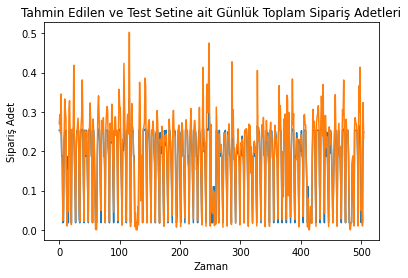

In [45]:
plt.plot(y_pred)
plt.plot(y_test)
plt.title('Tahmin Edilen ve Test Setine ait Günlük Toplam Sipariş Adetleri')
plt.ylabel('Sipariş Adet')
plt.xlabel('Zaman')

# Bütün verilere ait tahminleri ve ham veriyi görselleştirelim.

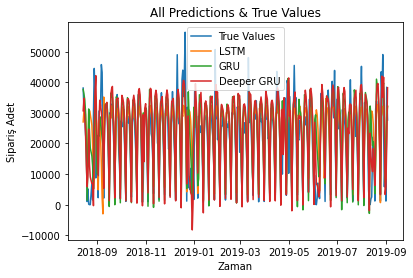

In [46]:
plt.plot(df_final['order_quantity'],label='True Values')
plt.plot(deneme_1_pred,label='LSTM')
plt.plot(deneme_2_pred,label='GRU')
plt.plot(deneme_3_pred,label='Deeper GRU')
plt.xlabel('Zaman')
plt.ylabel('Sipariş Adet')
plt.title('All Predictions & True Values')
plt.legend()

# Değerlendirme
## - En iyi sonuca, "0,003" değeriyle daha ilkel bir makine öğrenmesi yöntemi olan RandomForestRegressor ulaşmıştır. 
## - Hiçbir modelde optimizasyon kullanılmamıştır. Yapay sinir ağlarını optimize ettiğimizde daha iyi sonuca ulaşacağını düşünüyorum.

In [47]:
from IPython.display import HTML, display
from tabulate import tabulate
display(HTML('<h3>Farklı Modeller İçin MeanSquaredError Karşılaştırması</h3>'+tabulate([['MSE Score', 0.0063, 0.0051, 0.0043, 0.0030]],\
                      ["", "LSTM (Deneme-1)", "GRU (Deneme-2)", 'Derin GRU (Deneme-3)', 'RandomForestRegressor (Deneme-4)'], tablefmt="html")))

,LSTM (Deneme-1),GRU (Deneme-2),Derin GRU (Deneme-3),RandomForestRegressor (Deneme-4)
MSE Score,0.0063,0.0051,0.0043,0.003


# Neler yapılabilirdi?
## - Veriye ait çeşitli öznitelikler kullanılmadı. Bu öznitelikler de veriye eklenebilirdi.
## - Veriye ait öznitelikler üzerinden yeni öznitelikler çıkarılabilirdi. Yapay sinir ağlarında çok etkisi olmasa da klasik makine öğrenmesi yöntemlerinde ciddi etki yaratabilmektedir.
## - Çeşitli optimizasyonlar eklenebilirdi.
## - Pencere ve yığın sayıları optimize edilebilirdi.
## - Farklı modellerin ortak sonuçlar ürettiği "ensemble learning" yöntemleri kullanılabilirdi.
### [Notebook Link For Kaggle](https://www.kaggle.com/dasmehdixtr/multivariate-time-series-prediction-w-rnns)